In [40]:
library(edgeR)
library(magrittr)
library(ggplot2)
library(DESeq2)

# Automatise

In [134]:
x=read.csv("/fast/AG_Huebner/huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/Global_touse/ALL_CELLSTATE_PSEUDOBULK_LV.csv", check.names=FALSE)
genes_tofilter=read.csv("/fast/AG_Huebner/huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/Global_touse/ALL_CELLSTATE_PSEUDOBULK_FILTERING_LV.csv", check.names=FALSE)
colnames(genes_tofilter) <- gsub("mutation.negative", 'PVneg', colnames(genes_tofilter))
colnames(genes_tofilter)[1]='X' # since check.names=FALSE remove 'X' from the first column name

# Only needed for the column cell_state
CELLTYPE_STATE <- read.csv("/fast/AG_Huebner/huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/Global_touse/CELLSTATE_TRANSLATION_TABLE.csv")
colnames(CELLTYPE_STATE) <- c("cell_states", 'cell_type')

# Removes patients with only few (<10) nuclei numbers (as they might bias the analysis)
CELLTYPE_FILTER <- read.csv("/fast/AG_Huebner/huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/Global_touse/ABSOLUTE_CELLSTATES_NUMBER_LV.csv")


rownames(x) <- x$X
x <- x[,-1]
l <- strsplit(colnames(x), "__")

In [113]:
meta.data <- t(as.data.frame(l))
rownames(meta.data) <- colnames(x)

meta.data <- as.data.frame(meta.data)
colnames(meta.data)  <-  c("Genotype", "cell_state", 'Patient', 'X10X_version', 'Gender')

In [114]:
head(meta.data)

,Genotype,cell_state,Patient,X10X_version,Gender
,<fct>,<fct>,<fct>,<fct>,<fct>
LMNA__AD1.0__DL2__V3__m,LMNA,AD1.0,DL2,V3,m
LMNA__AD1.0__H05__V3__m,LMNA,AD1.0,H05,V3,m
LMNA__AD1.0__H26__V3__f,LMNA,AD1.0,H26,V3,f
LMNA__AD1.0__H28__V3__m,LMNA,AD1.0,H28,V3,m
LMNA__AD1.0__H31__V3__m,LMNA,AD1.0,H31,V3,m
LMNA__AD1.1__H05__V3__m,LMNA,AD1.1,H05,V3,m


In [115]:
GENOTYPES <- unique(meta.data$Genotype)[-6]
GENOTYPES

[1] LMNA  PKP2  PVneg RBM20 TTN  
Levels: control LMNA PKP2 PVneg RBM20 TTN

In [116]:
CELL_LEVEL <- "CELLSTATE"
REGION <- "LV"
#CELLTYPE <- "FB"

In [142]:
CELLTYPE_FILTER_SUB <- CELLTYPE_FILTER
CELLTYPE_FILTER_SUB[,2:ncol(CELLTYPE_FILTER_SUB)] <- apply(CELLTYPE_FILTER_SUB[,-1], 2, function(i) i>5)

In [139]:
i <- 1

for(GENOTYPE in as.character(GENOTYPES)){
    message("\n###START: ", GENOTYPE," #####\n")
    for(CELL_STATE in as.character(unique(meta.data$cell_state))){
        
        CONTROL_COLUMN <- paste("control_",CELL_STATE, sep="")
        GENOTYPE_COLUMN <- paste(GENOTYPE,"_", CELL_STATE, sep="")
        CELLTYPE <- as.character(CELLTYPE_STATE[which(CELLTYPE_STATE$cell_states==CELL_STATE),"cell_type"])
        
        
        x_sub <- x[,which(meta.data$Genotype %in% c("control", GENOTYPE))]
        meta.data_sub <- meta.data[which(meta.data$Genotype %in% c("control", GENOTYPE)),]
        
        x_sub <- x_sub[,which(meta.data_sub$cell_state %in% c(CELL_STATE))]
        meta.data_sub <- meta.data_sub[which(meta.data_sub$cell_state %in% c(CELL_STATE)),]
        
        # Suggestion: Remove samples with less than 5 nuclei 
        PATIENTS_TOKEEP <- CELLTYPE_FILTER_SUB[which(CELLTYPE_FILTER_SUB$cell_states==CELL_STATE),-1]
        PATIENTS_TOKEEP <- colnames(PATIENTS_TOKEEP)[which(as.logical(PATIENTS_TOKEEP))]
        x_sub <- x_sub[,which(meta.data_sub$Patient %in% PATIENTS_TOKEEP)]
        meta.data_sub <- meta.data_sub[which(meta.data_sub$Patient %in% PATIENTS_TOKEEP),]
        
        # The test is only run, if 2 conditions have at least 2 patients
        if (length(unique(meta.data_sub$Genotype))==2 &
           all(table(meta.data_sub$Genotype)>2)
           ){
             # Prepare DGEList object
            meta.data_sub$Genotype <- as.factor(as.character(meta.data_sub$Genotype))
            dge <- DGEList(counts=x_sub, group=meta.data_sub$Genotype)
            
            # Filter genes based on expression, the qlf Object will be filtered to exclude them from FDR calculation
            keep <- genes_tofilter[,CONTROL_COLUMN]>0.0125 | ##### change & to | ##### 
                    genes_tofilter[,GENOTYPE_COLUMN]>0.0125
            #dge <- dge[keep, , keep.lib.sizes=FALSE]
    
            # PP, model matrix, https://www.nature.com/articles/nmeth.4612 (edgeRQLFDetRate)
            dge <- calcNormFactors(dge)
            cdr <- scale(colMeans(x_sub > 0))
            design <- model.matrix(~ cdr + meta.data_sub$Genotype)
    
            # 
            dge <- estimateDisp(dge, design = design)
            fit <- glmQLFit(dge, design = design)
            qlf <- glmQLFTest(fit)
    
            # For all
            tt <- topTags(qlf, n = Inf)
            
            # Only for "expressed/detected" genes
            tt_filtered <- topTags(qlf[keep,], n = Inf)
            
            tt$table[,"Gene"] <- as.character(rownames(tt$table))
            tt_filtered$table[,"Gene"] <- as.character(rownames(tt_filtered$table))
            tt_filtered$table[,"low_expression"] <- "F" #####  Low-expression column ##### 
            tt_filtered$table[,"FDR_plot"] <- -log10(tt_filtered$table$FDR) #####  For plotting Volcano, here we use FDR, not pValue  ##### 
            
            
            tt_merged <- merge(tt$table[,c("Gene", "logFC", "logCPM", 'F', 'PValue')], 
                               tt_filtered$table[,c("Gene", "FDR", "low_expression", "FDR_plot")], 
                               by="Gene", all=T)   
            
            # Replace NA FDRs with NA                   #####  ORDER CHANGED #####  
            tt_merged[which(is.na(tt_merged$FDR)),"FDR"] <- 1 
            
            EXPRESSION_MEAN <- genes_tofilter[,c("X", CONTROL_COLUMN, GENOTYPE_COLUMN)]
            colnames(EXPRESSION_MEAN) <- c("Gene", "mean_exp_control", 'mean_exp_genotype')
            tt_merged <- merge(tt_merged, EXPRESSION_MEAN, by="Gene")
    
            
            tt_merged[,"Region"] <- REGION
            tt_merged[,"annotation_level"] <- CELL_LEVEL
            tt_merged[,"cell_state"] <- CELL_STATE
            tt_merged[,"cell_type"] <- CELLTYPE
            tt_merged[,"comparison"] <- paste("control_", GENOTYPE, sep="")
            
            if(i==1){
                 final_df <- tt_merged   
            } else {
                final_df <- rbind(final_df, tt_merged)
            }
            
            i <- i + 1
            message("\n###FINISHED: ", CELL_STATE," #####\n")
        }
    }
}


###START: LMNA #####



###FINISHED: AD1.0 #####




In [80]:
head(final_df)

,Gene,logFC,logCPM,F,PValue,FDR,FDR_plot,mean_exp_control,mean_exp_genotype,Region,annotation_level,cell_state,cell_type,comparison
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,A1BG,-1.5451111,5.541366,1.40094923,0.4691289,1.0000000,NA,0.006944444,0.0000000,RV,CELLSTATE,AD1.0,AD,control_LMNA
2,A1BG-AS1,-0.5612890,5.535025,0.44029902,0.7030519,1.0000000,NA,0.003227908,0.0000000,RV,CELLSTATE,AD1.0,AD,control_LMNA
3,A1CF,-0.5612890,5.535025,0.44029902,0.7030519,1.0000000,NA,0.003227908,0.0000000,RV,CELLSTATE,AD1.0,AD,control_LMNA
4,A2M,-0.2172196,6.366405,0.02657843,0.8712801,0.9997129,0.0001247056,0.071692444,0.1666667,RV,CELLSTATE,AD1.0,AD,control_LMNA
5,A2M-AS1,-1.1255241,5.551516,0.92790663,0.5562660,1.0000000,NA,0.010503040,0.0000000,RV,CELLSTATE,AD1.0,AD,control_LMNA
6,A2ML1,2.0501379,5.761197,2.78628462,0.1572151,1.0000000,NA,0.006283069,0.1111111,RV,CELLSTATE,AD1.0,AD,control_LMNA


In [81]:
tail(final_df)

,Gene,logFC,logCPM,F,PValue,FDR,FDR_plot,mean_exp_control,mean_exp_genotype,Region,annotation_level,cell_state,cell_type,comparison
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
12543207,ZXDB,-1.375883e-15,9.497553,0.000000,1.0000000,1,NA,0.000,0,RV,CELLSTATE,unclassfied.2,Lymphoid,control_TTN
12543208,ZXDC,-1.375883e-15,9.497553,0.000000,1.0000000,1,NA,0.000,0,RV,CELLSTATE,unclassfied.2,Lymphoid,control_TTN
12543209,ZYG11A,-1.375883e-15,9.497553,0.000000,1.0000000,1,NA,0.000,0,RV,CELLSTATE,unclassfied.2,Lymphoid,control_TTN
12543210,ZYG11B,-1.375883e-15,9.497553,0.000000,1.0000000,1,NA,0.000,0,RV,CELLSTATE,unclassfied.2,Lymphoid,control_TTN
12543211,ZYX,-2.629093e+00,9.637605,1.818158,0.1775372,1,NA,0.125,0,RV,CELLSTATE,unclassfied.2,Lymphoid,control_TTN
12543212,ZZEF1,-4.144908e+00,10.188582,2.309834,0.1285625,1,NA,1.250,0,RV,CELLSTATE,unclassfied.2,Lymphoid,control_TTN


In [83]:
table(final_df$cell_state)


           AD1.0            AD1.1              AD2                B 
          167690           167690           167690           167690 
        B_plasma         CD16..Mo        CD4.T_act      CD4.T_naive 
          167690           167690           167690           167690 
       CD4.T_reg      CD8.T_cytox         CD8.T_em         CD8.T_te 
          167690           167690           167690           167690 
     CD8.T_trans             cDC1             cDC2            EC1.0 
          167690           167690           167690           167690 
           EC2.0            EC5.0            EC6.0            EC7.0 
          167690           167690           167690           167690 
           EC8.0              ILC        MAIT.like             Mast 
          167690           167690           167690           167690 
            Meso              MY1             MY10             MY12 
          167690           167690           167690           167690 
            MY14             MY15

In [84]:
write.csv(final_df, "/fast/AG_Huebner/huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/Global_touse/ALLCELLSTATES_ALLGENOTYPES_EDGER_RV.csv")

Check that all genes have a ldFC - FDR is set to 1 for lowly-expressed genes

In [85]:
dim(final_df[which(final_df$cell_state %in% c("vFB2") & final_df$comparison %in% c("control_TTN")),])

[1] 33538    14

In [86]:
dim(final_df[which(final_df$cell_state %in% c("vFB4") & final_df$comparison %in% c("control_PKP2")),])

[1] 33538    14

Warning message:
“Removed 21274 rows containing missing values (geom_point).”
Warning message:
“Removed 21328 rows containing missing values (geom_point).”
Warning message:
“Removed 21127 rows containing missing values (geom_point).”


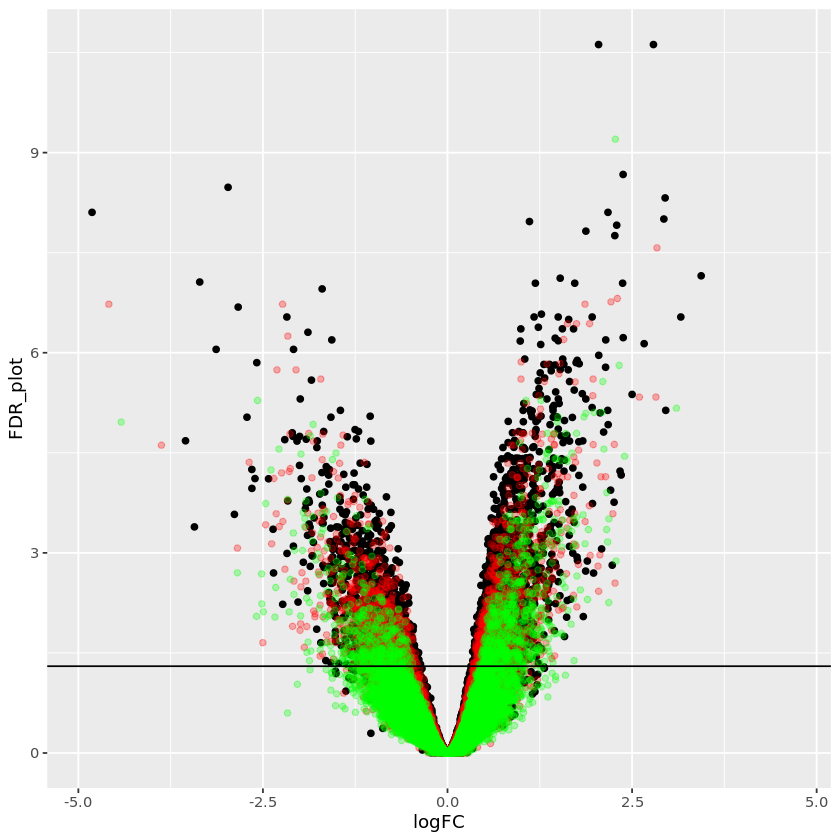

In [48]:
g <- ggplot(final_df[which(final_df$cell_state %in% c("vFB2") & final_df$comparison %in% c("control_TTN")),], 
            aes(x=logFC, y=FDR_plot)) + geom_point()

g <- g + geom_point(data=final_df[which(final_df$cell_state %in% c("vFB2") & final_df$comparison %in% c("control_LMNA")),], 
            aes(x=logFC, y=FDR_plot), color="red", alpha=0.3)

g + geom_point(data=final_df[which(final_df$cell_state %in% c("vFB2") & final_df$comparison %in% c("control_RBM20")),], 
            aes(x=logFC, y=FDR_plot), color="green", alpha=0.3) + geom_hline(yintercept=-log10(0.05))



In [57]:
tmp <- merge(final_df[which(final_df$cell_state %in% c("vFB2") & final_df$comparison %in% c("control_TTN")),],
             final_df[which(final_df$cell_state %in% c("SMC1.2") & final_df$comparison %in% c("control_LMNA")),],
             by="Gene", all=T)

In [58]:
dim(tmp)

[1] 33538    27

In [59]:
dim(tmp[unique(c(which(tmp[,"FDR.x"]<0.05), which(tmp[,"FDR.y"]<0.05))),])

[1] 2758   27

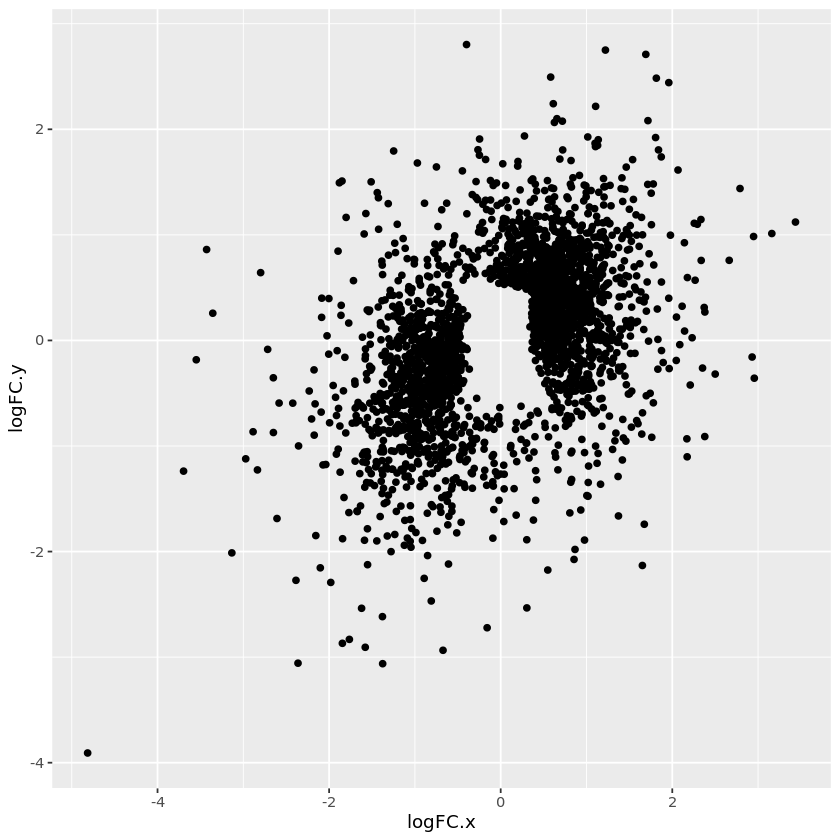

In [60]:
ggplot(tmp[unique(c(which(tmp[,"FDR.x"]<0.05), which(tmp[,"FDR.y"]<0.05))),], 
       aes(x=logFC.x, y=logFC.y)) + geom_point()

In [61]:
tmp[,"residuals"] <- residuals(lm(tmp[,"logFC.x"]~tmp[,"logFC.y"]))

In [62]:
yy <- tmp[unique(c(which(tmp[,"FDR.x"]<0.05), which(tmp[,"FDR.y"]<0.05))),]
yy <- yy[order(yy$residuals, decreasing=F),]
yy[,c("Gene", "logFC.x", "logFC.y")]

,Gene,logFC.x,logFC.y
,<chr>,<dbl>,<dbl>
12717,CCL2,-4.814640,-3.90797060
24100,NR4A1,-3.427883,0.86095700
17657,HES1,-3.548460,-0.18339323
6926,ADAMTS4,-3.696555,-1.23804579
15144,EDNRB,-3.356060,0.25771076
23128,MRVI1,-2.798148,0.64209550
14103,CTSC,-3.133851,-2.01241781
943,AC007529.2,-2.972026,-1.12145437
14728,DLK1,-2.886189,-0.86508260


In [159]:
yy <- yy[order(yy[,"mean_exp_control.x"], decreasing=F),]

In [160]:
head(yy, n=20)

,Gene,logFC.x,logCPM.x,F.x,PValue.x,FDR.x,FDR_plot.x,mean_exp_control.x,mean_exp_genotype.x,Region.x,⋯,PValue.y,FDR.y,FDR_plot.y,mean_exp_control.y,mean_exp_genotype.y,Region.y,annotation_level.y,cell_state.y,comparison.y,residuals
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
8339,AL157895.1,1.6541256,3.606893,15.7841909,2.654386e-04,0.0039054128,2.408333,0.01250340,0.04650262,LV,⋯,8.331035e-02,0.2397449487,0.6202505,0.01250340,0.023441069,LV,CELLSTATE,vFB2,control_LMNA,1.06706105
16948,GLDN,1.7448130,3.242857,14.1461455,5.050557e-04,0.0062793568,2.202085,0.01250601,0.03151350,LV,⋯,2.838194e-05,0.0013479207,2.8703357,0.01250601,0.043449280,LV,CELLSTATE,vFB2,control_LMNA,0.29501001
15014,DUOXA1,1.4694442,3.179165,10.9873776,1.865729e-03,0.0161549809,1.791694,0.01276257,0.03090648,LV,⋯,3.672235e-04,0.0073645700,2.1328526,0.01276257,0.039942170,LV,CELLSTATE,vFB2,control_LMNA,0.35207999
32710,ZBTB14,1.1885350,3.161043,11.2826817,1.644484e-03,0.0148931707,1.827013,0.01337365,0.03078727,LV,⋯,3.393780e-02,0.1362033039,0.8658124,0.01337365,0.029205637,LV,CELLSTATE,vFB2,control_LMNA,0.53038019
4573,AC092164.1,1.8055626,3.472746,27.1664766,5.002291e-06,0.0002244284,3.648922,0.01337950,0.04224449,LV,⋯,1.838791e-03,0.0205332482,1.6875423,0.01337950,0.038024366,LV,CELLSTATE,vFB2,control_LMNA,0.86492213
21971,LRMP,1.2380871,3.287981,10.4882992,2.314175e-03,0.0189567732,1.722236,0.01338096,0.03222554,LV,⋯,1.244340e-02,0.0720919585,1.1421132,0.01338096,0.032029398,LV,CELLSTATE,vFB2,control_LMNA,0.54371687
18857,INMT-MINDY4,1.1469103,3.121680,8.9969488,4.478359e-03,0.0302527660,1.519235,0.01340082,0.03161808,LV,⋯,8.499752e-03,0.0559918087,1.2518755,0.01340082,0.025928916,LV,CELLSTATE,vFB2,control_LMNA,0.33563394
20063,LINC00222,1.2578970,3.426267,10.4509031,2.352081e-03,0.0191066306,1.718816,0.01352112,0.04263292,LV,⋯,1.394373e-04,0.0039965136,2.3983187,0.01352112,0.046548580,LV,CELLSTATE,vFB2,control_LMNA,0.17421568
3451,AC055855.2,1.1111346,3.331609,8.4372213,5.777335e-03,0.0364801241,1.437944,0.01357349,0.03191315,LV,⋯,2.603241e-01,0.4842286411,0.3149495,0.01357349,0.022589197,LV,CELLSTATE,vFB2,control_LMNA,0.75513761


In [ ]:
edgeR_DEgenes_allstates_STEP7.1

In [5]:
all_DEGs <- read.csv("/fast/AG_Huebner/huebner3/ANALYSES/20190926_gp_BadOyenhausen/scanpy/20210302/Global_touse/ALLCELLSTATES_ALLGENOTYPES_EDGER_RV.csv")

In [6]:
all_DEGs[1:5,]

,X,Gene,logFC,logCPM,F,PValue,FDR,FDR_plot,mean_exp_control,mean_exp_genotype,Region,annotation_level,cell_state,cell_type,comparison
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
1,1,A1BG,-1.5451111,5.541366,1.40094923,0.4691289,1.0000000,NA,0.006944444,0.0000000,RV,CELLSTATE,AD1.0,AD,control_LMNA
2,2,A1BG-AS1,-0.5612890,5.535025,0.44029902,0.7030519,1.0000000,NA,0.003227908,0.0000000,RV,CELLSTATE,AD1.0,AD,control_LMNA
3,3,A1CF,-0.5612890,5.535025,0.44029902,0.7030519,1.0000000,NA,0.003227908,0.0000000,RV,CELLSTATE,AD1.0,AD,control_LMNA
4,4,A2M,-0.2172196,6.366405,0.02657843,0.8712801,0.9997129,0.0001247056,0.071692444,0.1666667,RV,CELLSTATE,AD1.0,AD,control_LMNA
5,5,A2M-AS1,-1.1255241,5.551516,0.92790663,0.5562660,1.0000000,NA,0.010503040,0.0000000,RV,CELLSTATE,AD1.0,AD,control_LMNA


In [18]:
both_thres <- which(all_DEGs[,"mean_exp_control"] > 0.0125 &
      all_DEGs[,"mean_exp_genotype"] > 0.0125)

In [19]:
one_thres <- which(all_DEGs[,"mean_exp_control"] > 0.0125 |
      all_DEGs[,"mean_exp_genotype"] > 0.0125)

In [21]:
only_one <- one_thres[-which(one_thres %in% both_thres)]

In [23]:
all_DEGs[only_one,]

,X,Gene,logFC,logCPM,F,PValue,FDR,FDR_plot,mean_exp_control,mean_exp_genotype,Region,annotation_level,cell_state,cell_type,comparison
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
6,6,A2ML1,2.050138,5.761197,2.7862846,0.15721507,1,NA,0.006283069,0.11111111,RV,CELLSTATE,AD1.0,AD,control_LMNA
10,10,A4GALT,-2.858647,6.059113,1.8425762,0.20923914,1,NA,0.042201694,0.00000000,RV,CELLSTATE,AD1.0,AD,control_LMNA
20,20,AAED1,-3.455630,6.171693,3.2408983,0.07993179,1,NA,0.061897054,0.00000000,RV,CELLSTATE,AD1.0,AD,control_LMNA
26,26,AAR2,-2.937260,5.830764,2.2948428,0.17914413,1,NA,0.049918090,0.00000000,RV,CELLSTATE,AD1.0,AD,control_LMNA
29,29,AARS2,-1.931518,5.678284,1.5983117,0.35991639,1,NA,0.014237393,0.00000000,RV,CELLSTATE,AD1.0,AD,control_LMNA
32,32,AASDHPPT,-2.269088,5.955852,1.5873719,0.26067968,1,NA,0.041307450,0.00000000,RV,CELLSTATE,AD1.0,AD,control_LMNA
37,37,AB015752.1,2.312347,5.632697,5.1864624,0.16556151,1,NA,0.005260428,0.02380952,RV,CELLSTATE,AD1.0,AD,control_LMNA
39,39,ABAT,-1.951226,5.795860,1.1746596,0.41175860,1,NA,0.035637360,0.00000000,RV,CELLSTATE,AD1.0,AD,control_LMNA
53,53,ABCB1,-1.565474,5.624132,1.2197007,0.46354187,1,NA,0.012853417,0.00000000,RV,CELLSTATE,AD1.0,AD,control_LMNA


In [32]:
tmp <- all_DEGs[which(all_DEGs[,"Gene"]=="IL11"),]
tmp[which(tmp[,"mean_exp_genotype"]>0.0125),]

,X,Gene,logFC,logCPM,F,PValue,FDR,FDR_plot,mean_exp_control,mean_exp_genotype,Region,annotation_level,cell_state,cell_type,comparison
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
2198696,2198696,IL11,2.966470,2.692850,5.392658,0.08867347,1,NA,0.001078132,0.02556818,RV,CELLSTATE,vCM3.1,CM,control_LMNA
9845360,9845360,IL11,2.485331,4.315949,12.299519,0.00397321,1,NA,0.009523810,0.01587302,RV,CELLSTATE,vFB1.1,FB,control_RBM20
11388108,11388108,IL11,1.032349,9.248712,5.685125,0.11867149,1,NA,0.000000000,0.16666667,RV,CELLSTATE,NC1.4,N,control_TTN
